In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch, os
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np


In [2]:
df_2019 = pd.read_csv(f'/data/jmharja/projects/PersonaClassifier/twitter_SU/classification/2019_personality.csv')
df_2020 = pd.read_csv(f'/data/jmharja/projects/PersonaClassifier/twitter_SU/classification/2020_personality.csv')
df_2021 = pd.read_csv(f'/data/jmharja/projects/PersonaClassifier/twitter_SU/classification/2021_personality.csv')
df_2019.shape, df_2020.shape, df_2021.shape

((2799726, 22), (3502171, 22), (2553235, 22))

In [3]:
fentanyl = ['blonde', 'fenty', 'goodfellas', 'poson', 'blues', 'freddy', 'great bear', 'birria', 'dance fever', 'fuf', 'opes', 'takeover'] + ['apache', 'China Girl', 'China Town', 'Dance Fever', 'Friend', 'Goodfellas', 'Great Bear', 'He-Man', 'Jackpot', 'King Ivory', 'Murder 8', 'Tango and Cash', 'Tango & Cash']
drug_keywords_map= {
'tobacco' : ['nicotine', 'tobacco', 'cigarette', 'cigarrette', 'cigar', 'bidis', 'snuff'],
'alcohol' : ['liquor', 'beer', 'wine'],
'cannabinoids' : ['marijuana', 'blunt', 'dope', 'ganja', 'grass', 'herb', 'joint', 'bud', 'mary jane', 'pot', 'reefer', 'green', 'trees', 'smoke', 'sinsemilla', 'skunk', 'weed','hashish', 'boom', 'gangster', 'hash', 'hash oil', 'hemp'],
'opioids' : ['heroin', 'smack', 'horse', 'brown sugar', 'dope', 
             # 'H',
             'junk', 'skag', 'skunk', 'white horse', 'China white','opium', 'laudanum', 'paregoric', 'big O', 'black stuff', 'block', 'gum', 'hop'],
'stimulants': ['cocaine', 'hydrochloride', 'blow', 'bump',
               # 'C',
                'candy', 'Charlie', 'coke', 'crack', 'flake', 'rock', 'snow', 'toot','amphetamine', 'Biphetamine', 'Dexedrine', 'bennies', 'black beauties', 'crosses', 'hearts', 'LA turnaround', 'speed', 'truck drivers', 'uppers','methamphetamine', 'Desoxyn','meth', 'ice', 'crank', 'chalk', 'crystal', 'fire', 'glass', 'go fast', 'speed'],
'club_drugs':['mdma', 'ecstasy', 'adam', 'clarity', 'eve', "lover's speed", 'peace', 'uppers','flunitrazepam', 'rohypnol', 'forget-me pill', 'mexican valium', 'r2', 'roach', 'roche', 'roffles', 'roofinol', 'rope', 'rophies','ghb', 'Gamma-hydroxybutyrate', 
              # 'G',
              'Georgia home boy', 'grievous bodily harm', 'liquid ecstasy', 'soap', 'scoop', 'goop', 'liquid X'],
'dissociative_drugs':['ketamine', 'Ketalar SV', 'cat Valium',
                      # 'K',
                      'Special K', 'vitamin K','pcp and analogs', 'phencyclidine' 'angel dust', 'boat', 'hog', 'love boat', 'peace pill','salvia divinorum', 'salvia', 'shepherdess’s herb', 'maria pastora', 'magic mint', 'sally-d','dextromethorphan', 'dxm',  'robotripping', 'robo', 'triple'],
'hallucinogens':['lsd','Lysergic acid diethylamide', 'acid', 'blotter', 'cubes', 'microdot', 'yellow sunshine', 'blue heaven', 'mescaline', 'Buttons', 'cactus', 'mesc', 'peyote', 'psilocybin', 'Magic mushrooms', 'purple passion', 'shrooms', 'little smoke'],
'other_compounds':['anabolic_steroids', 'Anadrol', 'Oxandrin', 'Durabolin', 'Depo-Testosterone', 'Equipoise', 'roids', 'juice', 'gym candy', 'pumpers','inhalants', 'Solvents', 'paint thinners', 'gasoline', 'glues', 'gasses', 'butane', 'propane', 'aerosol propellants', 'nitrous oxide',  'nitrites' ,'isoamyl', 'isobutyl', 'cyclohexyl','laughing gas', 'poppers', 'snappers', 'whippets'],
'prescription_medications':['cns_depressants', 'stimulants', 'opioid pain relievers', 'OxyContin','Oxycodone', 'Vicodin', 'Norco', 'Lortab', 'Hydrocodone', 'Acetaminophen', 'Percocet ', 'Oxycodone', 'Acetaminophen','Tramadol','Codeine','Morphine','Methadone','Demerol', 'meperidine','Acetaminophen','Tylenol', 'Excedrin', 'Vanquish','Aspirin', 'Bayer', 'Bufferin', 'Ecotrin', 'Excedrin', 'Vanquish','Diclofenac', 'Voltaren Gel','Ibuprofen', 'Advil', 'Motrin IB','Naproxen', 'Aleve']
}

drug_cols = drug_keywords_map.keys()

In [4]:
# https://nida.nih.gov/sites/default/files/cadchart.pdf
for keyword, words in drug_keywords_map.items():
    pattern = fr'\b(?:{"|".join(words)})\b'
    # print(f'Keyword: {keyword}, Pattern: {pattern}')
    df_2019[keyword] = df_2019['text'].str.contains(pattern, case=False).astype(int)
    df_2020[keyword] = df_2020['text'].str.contains(pattern, case=False).astype(int)
    df_2021[keyword] = df_2021['text'].str.contains(pattern, case=False).astype(int)

In [5]:
df_2019['drug_type'] = df_2019[drug_cols].apply(lambda row: next((col for col, val in zip(drug_cols, row) if val == 1), None), axis=1)
df_2020['drug_type'] = df_2020[drug_cols].apply(lambda row: next((col for col, val in zip(drug_cols, row) if val == 1), None), axis=1)
df_2021['drug_type'] = df_2021[drug_cols].apply(lambda row: next((col for col, val in zip(drug_cols, row) if val == 1), None), axis=1)

In [6]:
years = [2019, 2020, 2021]
age_groups = ['<=18','19-29', '30-39', '>=40']
age_mapping = {
    '<=18': 0,
    '19-29': 1,
    '30-39': 2,
    '>=40': 3
}
gender_mapping = {
    'female': 0,
    'male': 1
}
race_groups = ['api', 'white', 'hispanic', 'black']
drugs_map = {
            'tobacco' :'Tobacco',
            'alcohol' : 'Alcohol',
            'cannabinoids' : 'Cannabinoids',
            'opioids' : 'Opioids',
            'stimulants' : 'Stimulants',
            'club_drugs' : 'Club Drugs',
            'dissociative_drugs': 'Dissociative Drugs',
            'hallucinogens' : 'Hallucinogens',
            'other_compounds' : 'Other Compounds',
            'prescription_medications' : 'Prescription Medications'
}
substances = list(drugs_map.keys())
traits = ['cOPN', 'cCON', 'cEXT', 'cAGR', 'cNEU']

color_2019 = 'lightslategrey'
color_2020 = 'cadetblue'        # Steel Blue
color_2021 = 'steelblue' # Royal Blue
yearly_color = [color_2019, color_2020, color_2021]   # Blue, Green, Red
def alter_date (data):
    data['created_at'] = pd.to_datetime(data['created_at'], format='%a %b %d %H:%M:%S %z %Y')
    data['year'] = data['created_at'].dt.year
    data['quarter'] = data['created_at'].dt.to_period('Q')
    data['month'] = data['created_at'].dt.to_period('M')
    data['week'] = data['created_at'].dt.to_period('W')

def coerce_binary(data, col, mapping):
    data[col] = data[col].map(mapping)
    data[col] = pd.to_numeric(data[col], errors='coerce') 

In [7]:
data= pd.concat([df_2019, df_2020, df_2021], ignore_index=True)
# data= pd.concat( [df_2019], ignore_index=True)
alter_date(data)
coerce_binary(data, 'age', age_mapping)
coerce_binary(data, 'gender', gender_mapping)

/tmp/ipykernel_753633/955369605.py:36: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['quarter'] = data['created_at'].dt.to_period('Q')
/tmp/ipykernel_753633/955369605.py:37: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['month'] = data['created_at'].dt.to_period('M')
/tmp/ipykernel_753633/955369605.py:38: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['week'] = data['created_at'].dt.to_period('W')


In [ ]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

def generate_substance_table(data, yearr, age_group):
    all_results = []
    
    for substance in substances:
        subdata = data[data['year'] == yearr].copy()
        subdata = subdata[subdata['org'] != 'is-org']
        # subdata = subdata[subdata['age'] == age_group]
        subdata = subdata[traits + [substance]].dropna()
        
        X = subdata[traits]
        X = (X - X.mean()) / X.std()  
        y = subdata[substance]  
        X_sm = sm.add_constant(X)

        try:
            model_sm = sm.Logit(y, X_sm).fit(disp=0)
            odds_ratios = np.exp(model_sm.params)
            conf_int = np.exp(model_sm.conf_int())
            for i, trait in enumerate(traits):
                all_results.append({
                    'Substance': substance,
                    'Trait': trait,
                    'OR': odds_ratios[i+1],  # Skip intercept
                    'CI Lower': conf_int[0][i+1],
                    'CI Upper': conf_int[1][i+1],
                    'n': len(subdata[subdata[substance] == 1])
                })
        except:
            print(f"Could not estimate model for {substance} (possibly no cases)")
    
    results_df = pd.DataFrame(all_results)
    
    # Create formatted strings for OR and CI
    results_df['OR (95% CI)'] = results_df.apply(
        lambda x: f"{x['OR']:.2f} [{x['CI Lower']:.2f}, {x['CI Upper']:.2f}]", 
        axis=1
    )
    return results_df
results_df = generate_substance_table(data, 2020, age_group=0)
results_df.to_csv('substance_trait.csv')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

df = results_df
# --- JIMR Style Setup ---
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 9,
    'axes.titlesize': 11,
    'axes.labelsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'figure.titlesize': 12
})

# Create figure with two columns
fig = plt.figure(figsize=(14, 12), dpi=300)
gs = GridSpec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
sns.despine()

palette = {
    "tobacco": "#4e79a7",
    "alcohol": "#f28e2b",
    "cannabinoids": "#e15759",
    "opioids": "#76b7b2",
    "stimulants": "#59a14f",
    "club_drugs": "#edc948",
    "dissociative_drugs": "#b07aa1",
    "hallucinogens": "#ff9da7",
    "other_compounds": "#9c755f",
    "prescription_medications": "#bab0ac"
}

# Split substances into two groups
substances = df['Substance'].unique()
left_substances = substances[:5]
right_substances = substances[5:]

# --- LEFT PLOT ---
left_df = df[df['Substance'].isin(left_substances)]
left_df['y_pos'] = left_df.groupby('Substance').cumcount()
max_traits = left_df['Trait'].nunique()
left_df['y_pos'] += (left_df['Substance'].astype('category').cat.codes * (max_traits + 1))

# Error bars
for _, row in left_df.iterrows():
    ax1.plot(
        [row['CI Lower'], row['CI Upper']],
        [row['y_pos'], row['y_pos']],
        color=palette[row['Substance']],
        linewidth=1.2,
        solid_capstyle='butt'
    )

# Points
sns.scatterplot(
    data=left_df,
    x='OR',
    y='y_pos',
    hue='Substance',
    palette=palette,
    s=45,
    edgecolor='w',
    linewidth=0.5,
    ax=ax1
)

# Reference line
ax1.axvline(x=1, color='#444444', linestyle=':', linewidth=0.8)

# Y-axis
ax1.set_yticks(left_df['y_pos'])
ax1.set_yticklabels(left_df['Trait'])
ax1.set_ylabel("Personality Traits", fontweight='bold')

# X-axis
ax1.set_xlabel("Odds Ratio (95% CI)", fontweight='bold')
ax1.set_xlim(0.5, 1.8)
ax1.set_xticks(np.arange(0.5, 1.9, 0.1))

# Substance labels
for substance in left_substances:
    ymin = left_df[left_df['Substance'] == substance]['y_pos'].min() - 0.5
    ymax = left_df[left_df['Substance'] == substance]['y_pos'].max() + 0.5
    ax1.axhspan(ymin, ymax, facecolor=palette[substance], alpha=0.08)
    ax1.text(
        0.45, (ymin + ymax)/2, substance.replace("_", " ").title(),
        ha='right', va='center',
        transform=ax1.get_yaxis_transform(),
        fontsize=9,
        fontweight='bold',
        color=palette[substance]
    )

# --- RIGHT PLOT ---
right_df = df[df['Substance'].isin(right_substances)]
right_df['y_pos'] = right_df.groupby('Substance').cumcount()
right_df['y_pos'] += (right_df['Substance'].astype('category').cat.codes * (max_traits + 1))

# Error bars
for _, row in right_df.iterrows():
    ax2.plot(
        [row['CI Lower'], row['CI Upper']],
        [row['y_pos'], row['y_pos']],
        color=palette[row['Substance']],
        linewidth=1.2,
        solid_capstyle='butt'
    )

# Points
sns.scatterplot(
    data=right_df,
    x='OR',
    y='y_pos',
    hue='Substance',
    palette=palette,
    s=45,
    edgecolor='w',
    linewidth=0.5,
    ax=ax2
)

# Reference line
ax2.axvline(x=1, color='#444444', linestyle=':', linewidth=0.8)
ax2.set_ylabel("")
ax2.set_xlabel("Odds Ratio (95% CI)", fontweight='bold')
ax2.set_xlim(0.5, 1.8)
ax2.set_xticks(np.arange(0.5, 1.9, 0.1))

# Substance labels
for substance in right_substances:
    ymin = right_df[right_df['Substance'] == substance]['y_pos'].min() - 0.5
    ymax = right_df[right_df['Substance'] == substance]['y_pos'].max() + 0.5
    ax2.axhspan(ymin, ymax, facecolor=palette[substance], alpha=0.08)
    ax2.text(
        0.45, (ymin + ymax)/2, substance.replace("_", " ").title(),
        ha='right', va='center',
        transform=ax2.get_yaxis_transform(),
        fontsize=9,
        fontweight='bold',
        color=palette[substance]
    )

# --- Annotations for Both Plots ---
for ax in [ax1, ax2]:
    # Add OR values
    for _, row in (left_df if ax == ax1 else right_df).iterrows():
        ax.text(
            row['OR'] + 0.02, row['y_pos'] + 0.15,
            f"{row['OR']:.2f}",
            ha='left', va='bottom',
            fontsize=7
        )
    
    # Add sample sizes
    for _, row in (left_df if ax == ax1 else right_df).iterrows():
        ax.text(
            1.75, row['y_pos'], f"n={row['n']:,}",
            ha='right', va='center',
            fontsize=7,
            color='#555555'
        )

# Legend
handles = [plt.Line2D([0], [0], marker='o', color='w', 
            markerfacecolor=palette[s], markersize=8) for s in substances]
fig.legend(handles, [s.replace("_", " ").title() for s in substances],
           title='Substances',
           bbox_to_anchor=(0.5, 0.02), loc='lower center',
           ncol=5, frameon=False)
ax1.get_legend().remove()  # Remove legend from left plot
ax2.get_legend().remove()  # Remove legend from right plot
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)  # Make space for legend

# Save (uncomment if needed)
# plt.savefig('forest_plot_jimr_2panel.png', dpi=300, bbox_inches='tight')
plt.show()

(1257705, 8)


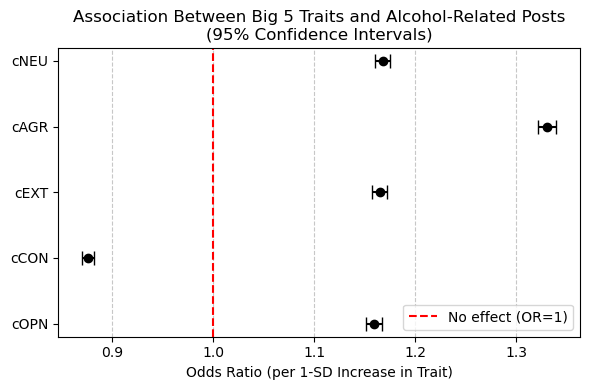

(1257705, 8)


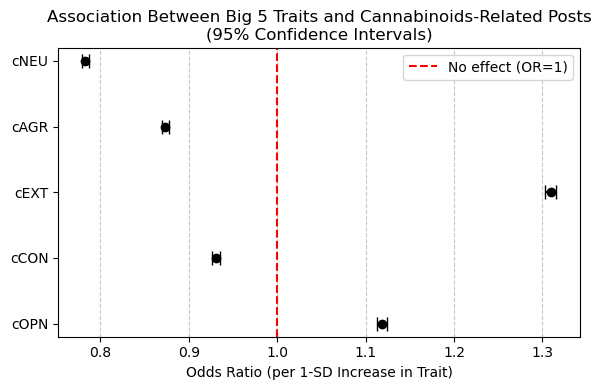

(1257705, 8)


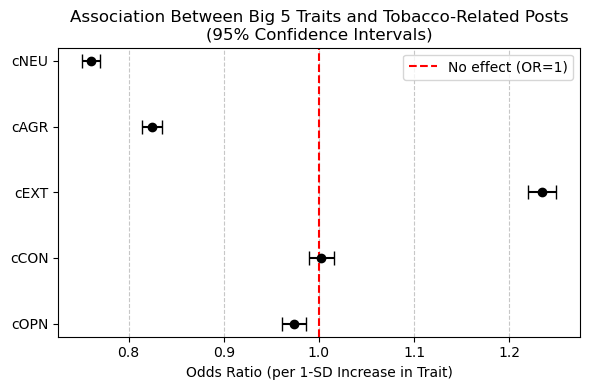

In [10]:
def plot_forest(data, yearr, substance, age_group):
    subdata = data[data['year'] ==  2020].copy()
    subdata = subdata[subdata['org'] !='is-org']
    subdata = subdata[subdata['age'] == age_group]
    subdata = subdata[traits + ['age', 'gender', substance]]
    subdata = subdata.dropna()
    print(subdata.shape)

    import statsmodels.api as sm
    X = subdata[traits]  
    X = (X - X.mean()) / X.std()  
    y = subdata[substance]  
    X_sm = sm.add_constant(X) 
    model_sm = sm.Logit(y, X_sm).fit(disp=0)  # disp=0 suppresses output

    odds_ratios = np.exp(model_sm.params)
    conf_int = np.exp(model_sm.conf_int())  # 95% CIs for ORs
    df_plot = pd.DataFrame({
        "Trait": ["Intercept"] + traits,
        "OR": odds_ratios,
        "CI Lower": conf_int[0],
        "CI Upper": conf_int[1]
    })

    df_plot = df_plot.iloc[1:] 
    plt.figure(figsize=(6, 4))
    plt.errorbar(df_plot["OR"], df_plot["Trait"], 
                xerr=[df_plot["OR"] - df_plot["CI Lower"], df_plot["CI Upper"] - df_plot["OR"]], 
                fmt='o', color='black', capsize=5)
    plt.axvline(x=1, color='red', linestyle='--', label="No effect (OR=1)")
    plt.xlabel("Odds Ratio (per 1-SD Increase in Trait)")
    plt.title(f"Association Between Big 5 Traits and {substance.capitalize()}-Related Posts\n(95% Confidence Intervals)")
    plt.legend()
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.tight_layout()
    # plt.savefig('alcohol/big5_alchol.png', bbox_inches='tight', pad_inches=0)
    plt.show()
    
plot_forest(data, 2020, 'alcohol', 0)
# plot_forest(data, 2020, 'cannabinoids', 0)
# plot_forest(data, 2020, 'tobacco', 0)

In [45]:
# def add_significance(df):
#     """Adds significance stars based on CIs"""
#     df['Significance'] = ''
#     df.loc[df['CI Lower'] > 1, 'Significance'] = '↑'
#     df.loc[df['CI Upper'] < 1, 'Significance'] = '↓'
#     df['OR Formatted'] = df.apply(
#         lambda x: f"{x['OR']:.2f}{x['Significance']}", axis=1)
#     return df

# results_df.groupby('Substance').apply(add_significance)[[ 'Trait', 'OR (95% CI)',	'Significance',	'OR Formatted']]
# results_df

In [33]:
# pivot_df = results_df.pivot(index='Substance', columns='Trait', values=['OR (95% CI)', 'n'])
# pivot_df.columns = [f"{col[1]}_{col[0]}" for col in pivot_df.columns]
# new_columns = []
# for trait in traits:
#     new_columns.append(f"{trait}_OR (95% CI)")
#     # new_columns.append(f"{trait}_n")
# pivot_df[new_columns]

                            OLS Regression Results                            
Dep. Variable:                alcohol   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                 1.030e+04
Date:                Tue, 08 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:17:18   Log-Likelihood:            -6.5802e+05
No. Observations:             3211992   AIC:                         1.316e+06
Df Residuals:                 3211986   BIC:                         1.316e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0105      0.001     -7.257      0.0

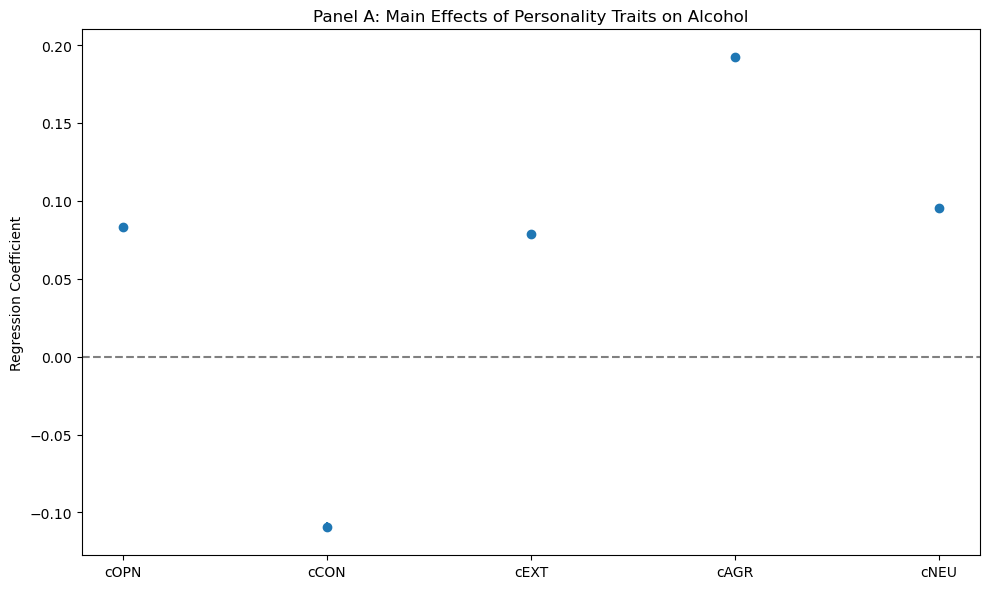

In [8]:
import statsmodels.api as sm
subdata = data[data['year'] ==  2020].copy()
subdata = subdata[subdata['org'] !='is-org']
X = subdata[traits]
X = sm.add_constant(X)  # Adds intercept term
y = subdata['alcohol']
model_a = sm.OLS(y, X).fit()
print(model_a.summary())

plt.figure(figsize=(10, 6))
coefs = model_a.params[1:]  # exclude intercept
ci = model_a.conf_int().iloc[1:]
plt.errorbar(x=coefs.index, y=coefs, yerr=[coefs-ci[0], ci[1]-coefs], fmt='o')
plt.axhline(0, color='grey', linestyle='--')
plt.title('Panel A: Main Effects of Personality Traits on Alcohol')
plt.ylabel('Regression Coefficient')
plt.tight_layout()

In [52]:
data.columns

Index(['id', 'created_at', 'text', 'user_id', 'name', 'screen_name',
       'description', 'DrugAbuse', 'lang', 'gender', 'age', 'org', 'date',
       'is_teenage', 'drug_type', 'sent_score', 'sentiment', 'cOPN', 'cCON',
       'cEXT', 'cAGR', 'cNEU', 'tobacco', 'alcohol', 'cannabinoids', 'opioids',
       'stimulants', 'club_drugs', 'dissociative_drugs', 'hallucinogens',
       'other_compounds', 'prescription_medications', 'year', 'quarter',
       'month', 'week'],
      dtype='object')

In [29]:
new_list = [t[1:] for t in traits]

['cOPN', 'cCON', 'cEXT', 'cAGR', 'cNEU']

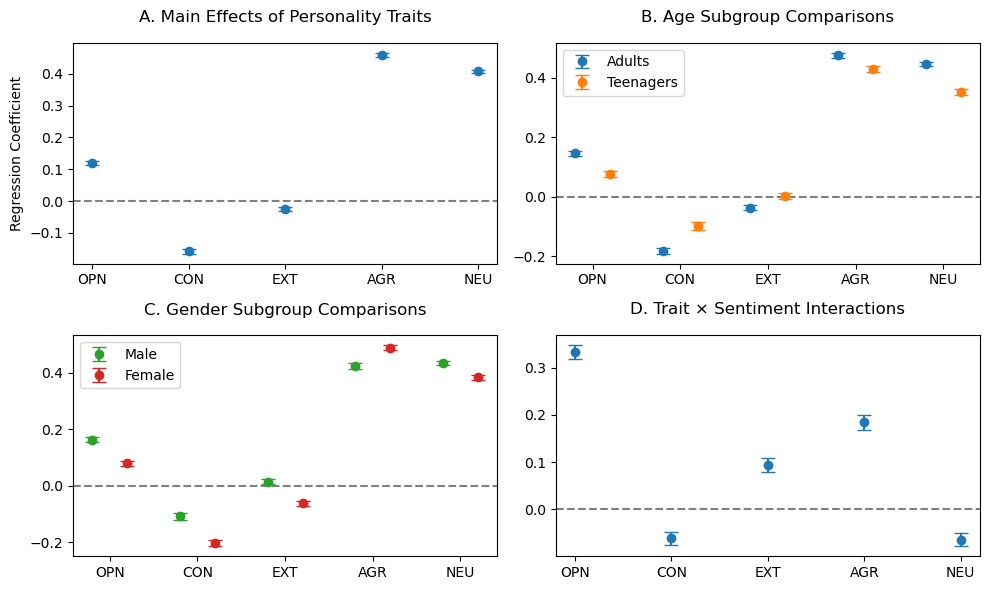

In [57]:
subdata = data[data['year'] ==  2020].copy()
subdata = subdata[subdata['org'] !='is-org']
subdata = subdata.dropna()
df = subdata
for trait in traits:
    df[f'{trait}_x_sentiment'] =  df[trait] * df['sent_score']

# =============================================
# 2. Run All Regression Models
# =============================================
# Panel A: Main effects
X_a = df[traits]
X_a = sm.add_constant(X_a)
model_a = sm.OLS(df['alcohol'], X_a).fit()
# Panel B: Age subgroups
models_b = {}
for age in [0, 1]:
    subset = df[df['is_teenage'] == age]
    X = subset[traits]
    X = sm.add_constant(X)
    models_b[age] = sm.OLS(subset['alcohol'], X).fit()

# Panel C: Gender subgroups
models_c = {}
for gender in [0, 1]:
    subset = df[df['gender'] == gender]
    X = subset[traits]
    X = sm.add_constant(X)
    models_c[gender] = sm.OLS(subset['alcohol'], X).fit()
# Panel D: Trait × Sentiment interactions
X_d = df[traits + ['cNEU_x_sentiment', 'cEXT_x_sentiment', 'cOPN_x_sentiment','cAGR_x_sentiment', 'cCON_x_sentiment']]
X_d = sm.add_constant(X_d)
model_d = sm.OLS(df['alcohol'], X_d).fit()

# =============================================
# 3. Create Multi-Panel Plot
# =============================================
plt.figure(figsize=(10, 6))
# plt.suptitle("Alcohol Use Regression Analysis", y=1.02, fontsize=16)

# --------------------------
# Panel A: Main Effects
# --------------------------
ax1 = plt.subplot(2, 2, 1)
coefs = model_a.params[1:6]
ci = model_a.conf_int().iloc[1:6]
ax1.errorbar(x=range(len(traits)), y=coefs, yerr=[coefs-ci[0], ci[1]-coefs], fmt='o', capsize=5)
ax1.axhline(0, color='grey', linestyle='--')
ax1.set_xticks(range(len(traits)))
ax1.set_xticklabels([t[1:] for t in traits])
ax1.set_title('A. Main Effects of Personality Traits', pad=15)
ax1.set_ylabel('Regression Coefficient')

# --------------------------
# Panel B: Age Subgroups
# --------------------------
ax2 = plt.subplot(2, 2, 2)
colors = {0: '#1f77b4', 1: '#ff7f0e'}
x_offset = np.linspace(-0.2, 0.2, 2)  # Offset for teen/adult points
age_map  = {0: 'Adults', 1: 'Teenagers'}
for i, (age, model) in enumerate(models_b.items()):
    coefs = model.params[1:6]
    ci = model.conf_int().iloc[1:6]
    ax2.errorbar(x=np.arange(len(traits)) + x_offset[i], y=coefs, yerr=[coefs-ci[0], ci[1]-coefs], fmt='o', capsize=5, color=colors[age], label=age_map[age])
ax2.axhline(0, color='grey', linestyle='--')
ax2.set_xticks(range(len(traits)))
ax2.set_xticklabels([t[1:] for t in traits])
ax2.set_title('B. Age Subgroup Comparisons', pad=15)
ax2.legend()

# --------------------------
# Panel C: Gender Subgroups
# --------------------------
ax3 = plt.subplot(2, 2, 3)
colors = {0: '#2ca02c', 1: '#d62728'}
genders  = {0: 'Male', 1: 'Female'}
for i, (gender, model) in enumerate(models_c.items()):
    coefs = model.params[1:6]
    ci = model.conf_int().iloc[1:6]
    ax3.errorbar(x=np.arange(len(traits)) + x_offset[i], y=coefs,yerr=[coefs-ci[0], ci[1]-coefs], fmt='o', capsize=5, color=colors[gender], label=genders[gender])
ax3.axhline(0, color='grey', linestyle='--')
ax3.set_xticks(range(len(traits)))
ax3.set_xticklabels([t[1:] for t in traits])
ax3.set_title('C. Gender Subgroup Comparisons', pad=15)
ax3.legend()

# --------------------------
# Panel D: Trait × Sentiment Interactions
# --------------------------
ax4 = plt.subplot(2, 2, 4)
interact_terms = [f'{t}_x_sentiment' for t in traits]
coefs = model_d.params[6:11]
ci = model_d.conf_int().iloc[6:11]
ax4.errorbar(x=range(len(traits)), y=coefs, yerr=[coefs-ci[0], ci[1]-coefs], fmt='o', capsize=5)
ax4.axhline(0, color='grey', linestyle='--')
ax4.set_xticks(range(len(traits)))
ax4.set_xticklabels([t[1:] for t in traits])
ax4.set_title('D. Trait × Sentiment Interactions',pad=15)

plt.tight_layout()
plt.savefig('figures/alcohol_regression_panels.png', dpi=300, bbox_inches='tight')
plt.show()

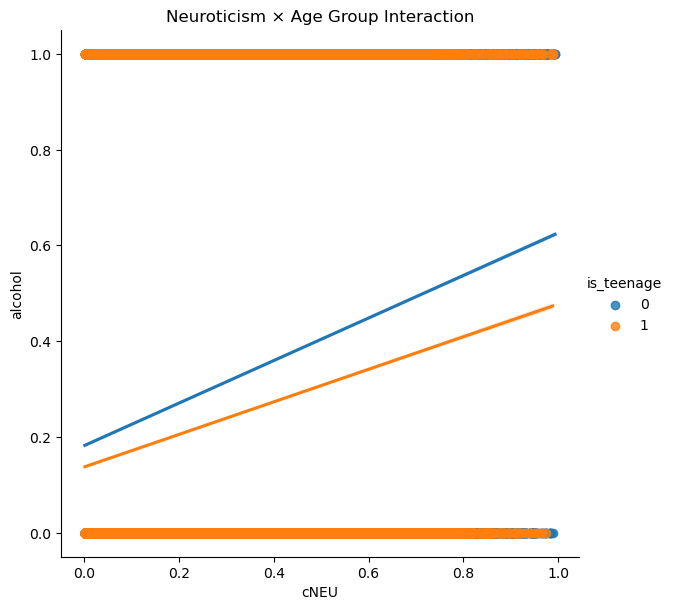

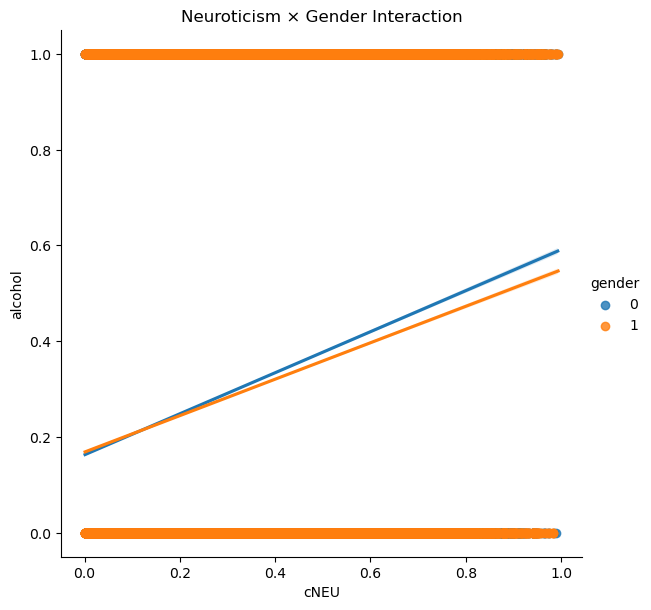

In [49]:
sns.lmplot(data=df, x='cNEU', y='alcohol', hue='is_teenage', ci=95, height=6)
plt.title("Neuroticism × Age Group Interaction")
plt.show()

sns.lmplot(data=df, x='cNEU', y='alcohol', hue='gender', ci=95, height=6)
plt.title("Neuroticism × Gender Interaction")
plt.show()

## . Text-Based Sentiment Interaction

In [52]:
subdata = data[data['year'] == 2020].copy()
subdata = subdata[subdata['org'] !='is-org']
subdata = subdata.dropna()
subdata = subdata[traits + ['alcohol'] +['sent_score']].dropna()
subdata['trait_x_sent'] = subdata['cNEU'] * subdata['sent_score']  # Interaction term
X = subdata[['cNEU', 'sent_score', 'trait_x_sent']]
X = (X - X.mean()) / X.std()  
y = subdata['alcohol'] 
sm.Logit(y, sm.add_constant(X)).fit().summary()


Optimization terminated successfully.
         Current function value: 0.317221
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                alcohol   No. Observations:              3211992
Model:                          Logit   Df Residuals:                  3211988
Method:                           MLE   Df Model:                            3
Date:                Tue, 08 Apr 2025   Pseudo R-squ.:                 0.02099
Time:                        12:58:13   Log-Likelihood:            -1.0189e+06
converged:                       True   LL-Null:                   -1.0408e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.2625      0.002  -1152.017      0.000      -2.266      -2.259
cNEU             0.1024      0.002     53.773      0.000       0.099       0.106
sent_score       0.2623      0.004     61.148      0.000       0.254       0.271
trait_x_sent     0.1130      0.004     27.663      0.000       0.105       0.121
================================================================================
"""

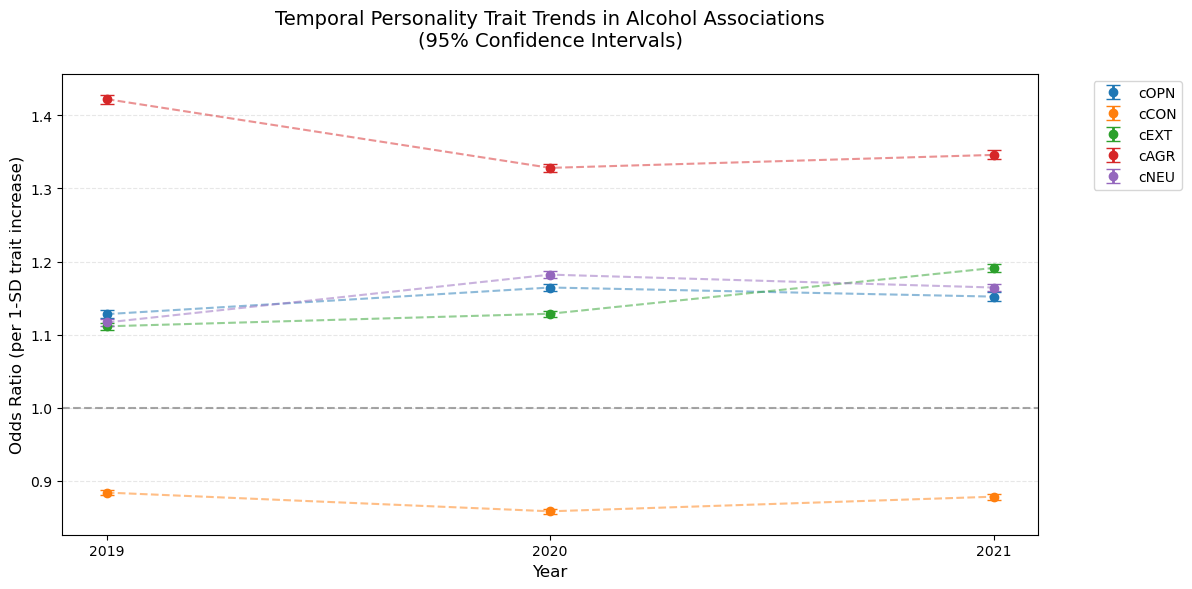

In [76]:
def plot_temporal_trends_with_lines(data, substance='alcohol'):
    results = []
    for year in [2019, 2020, 2021]:
        subdata = data[data['year'] == year].copy()
        subdata = subdata[subdata['org'] != 'is-org']
        subdata = subdata[traits + [substance]].dropna()
        X = subdata[traits]
        X = (X - X.mean()) / X.std()
        y = subdata[substance]
        model = sm.Logit(y, sm.add_constant(X)).fit(disp=0)
        for i, trait in enumerate(traits):
            results.append({'Year': year, 'Trait': trait, 'OR': np.exp(model.params[i+1]), 'CI_Lower': np.exp(model.conf_int()[0][i+1]), 'CI_Upper': np.exp(model.conf_int()[1][i+1]) })
    results_df = pd.DataFrame(results)
    plt.figure(figsize=(12, 6))
    trait_colors = { 'cOPN': '#1f77b4', 'cCON': '#ff7f0e', 'cEXT': '#2ca02c',  'cAGR': '#d62728', 'cNEU': '#9467bd' }   
    offset = np.linspace(-0.3, 0.3, len(traits))
    x_pos = np.arange(len(years))
    for i, trait in enumerate(traits):
        trait_data = results_df[results_df['Trait'] == trait].sort_values('Year')
        plt.plot(x_pos, trait_data['OR'], color=trait_colors[trait], linestyle='--', alpha=0.5,linewidth=1.5)
        plt.errorbar(x_pos,  trait_data['OR'], yerr=[trait_data['OR'] - trait_data['CI_Lower'], trait_data['CI_Upper'] - trait_data['OR']],fmt='o',color=trait_colors[trait],capsize=5,label=trait,linewidth=2)

    plt.axhline(y=1, color='gray', linestyle='--', alpha=0.7)
    plt.xticks(x_pos, [str(year) for year in years])
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Odds Ratio (per 1-SD trait increase)', fontsize=12)
    plt.title(f'Temporal Personality Trait Trends in {substance.capitalize()} Associations\n(95% Confidence Intervals)', fontsize=14, pad=20)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add pandemic annotation
    # plt.text(1, plt.ylim()[1]*0.95, 'Pandemic Period', ha='center', va='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
    # plt.axvspan(1+0.2, 1+0.6, color='red', alpha=0.07)
    plt.tight_layout()
    plt.savefig(f'figures/{substance}_temporal_trends_connected.png', dpi=300, bbox_inches='tight')
    plt.show()
    return results_df

# Generate plot
trend_results = plot_temporal_trends_with_lines(data, substance='alcohol')

In [54]:
#Latent Class Analysis (LCA)
from sklearn.mixture import BayesianGaussianMixture
lca = BayesianGaussianMixture(n_components=5).fit(data[substances])
data['substance_class'] = lca.predict(data[substances])

In [57]:
data.groupby('substance_class')['substance_class'].count()

substance_class
0    1368687
1    5876473
2     914348
3     558470
4     137154
Name: substance_class, dtype: int64

In [77]:
##  Topic analysis

In [ ]:
data

,id,created_at,text,user_id,name,screen_name,description,DrugAbuse,lang,gender,...,tobacco,alcohol,cannabinoids,opioids,stimulants,club_drugs,dissociative_drugs,hallucinogens,other_compounds,prescription_medications
0,1214331878381170694,Mon Jan 06 23:44:15 +0000 2020,nova jut give nose boop first ever boop proud ...,1034618872413020161,geralt hm fuck,lonioiHetairoi,Knell - 🇨🇦 26 - Pan - NB - they/them Nintendo ...,1,en,male,...,0,0,0,0,0,0,0,0,0,0
1,1214331916163305477,Mon Jan 06 23:44:24 +0000 2020,USER drink miche work today,537793543,Ruben,messywuben,NaN,1,en,male,...,0,0,0,0,0,0,0,0,0,0
2,1214331949717839873,Mon Jan 06 23:44:32 +0000 2020,go get drunk sleep,269070737,Le’🖤,__Lucy93,🌻 #fvsugraduate ig: letia93 ♎️☮️ 💫🧘🏾‍♀️ •••• •...,1,en,female,...,0,0,0,0,0,0,0,0,0,0
3,1214332046165913601,Mon Jan 06 23:44:55 +0000 2020,USER bring jacket bcos alcohol keep warm,1060380499292704776,tray🦋,traydominic,the muse | IG: @traydominic | ♊︎,1,en,female,...,0,0,0,0,0,0,0,0,0,0
4,1214332876629643265,Mon Jan 06 23:48:13 +0000 2020,gaspowered mower leaf blower weed whacker coul...,14093707,SFist,SFist,Everything else you need to know about SF & th...,1,en,male,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3502166,1344665680877121539,Thu Dec 31 15:24:15 +0000 2020,USER analogy “ drunk driving car accident kill...,2480289914,Kim,kimerlyus,NaN,1,en,female,...,0,0,0,0,0,0,0,0,0,0
3502167,1344665727035465736,Thu Dec 31 15:24:26 +0000 2020,USER well go bit rough patch whole year actual...,320322773,Christmas Coach,danielsamac,James 1:2-3. Atlanta sports why do you hate me...,1,en,male,...,0,0,0,0,0,1,0,0,0,0
3502168,1344665756378615808,Thu Dec 31 15:24:33 +0000 2020,USER dear you may never cry middle night again...,1116139204369453056,란,ranhmd,walking travesty,1,en,male,...,0,0,0,0,0,0,0,0,0,0
3502169,1344665789958402052,Thu Dec 31 15:24:41 +0000 2020,imiss get high,772098446,Deuce...,Swooshman22,P H E N O M E N A L XC | Instagram: NZST22,1,en,male,...,0,0,0,0,0,0,0,0,0,0


In [23]:
subdata = data[data['year'] == 2020].copy()
subdata = subdata[subdata['org'] != 'is-org']
subdata = subdata[subdata['alcohol'] == 1]
subdata = subdata[['text']+traits + ['alcohol']].dropna()
subdata.shape

(319650, 7)

In [24]:
subdata.to_csv('alcohol/2020_alcohol.csv')

In [ ]:
agr_data = subdata[subdata["cAGR"] > 0.50]
agr_data['text'].to_csv('alcohol/alcohol_agr.csv')
agr_data.shape

(98149, 7)

In [ ]:
neu_data = subdata[subdata["cNEU"] > 0.50]
neu_data['text'].to_csv('alcohol/alcohol_neu.csv')
neu_data.shape

(33032, 7)

In [ ]:
neu_data = subdata[subdata["cOPN"] > 0.50]
neu_data['text'].to_csv('alcohol/alcohol_opn.csv')
neu_data.shape

(171028, 7)

In [ ]:
neu_data = subdata[subdata["cCON"] > 0.50]
neu_data['text'].to_csv('alcohol/alcohol_con.csv')
neu_data.shape

(297526, 7)

In [ ]:
neu_data = subdata[subdata["cEXT"] > 0.50]
neu_data['text'].to_csv('alcohol/alcohol_ext.csv')
neu_data.shape

(194469, 7)

In [ ]:
# subdata[subdata["cAGR"] > subdata['cAGR'].mean()]["text"].to_csv('alcohol_agr.csv')
# subdata[subdata["cNEU"] > subdata['cNEU'].mean()]["text"].to_csv('alcohol_neu.csv')

In [86]:
agr_texts

['USER thank all mean it drink amp talk mama see tomorrow 2020 jan first',
 'USER fuck drink drive tonight asshole',
 'start new year drunk start well',
 'USER go drink drive',
 'USER drunk tell drunk throw HTTPURL',
 'USER fuck it go tonight HTTPURL',
 'might stop smoking tomorrow get super high tonight',
 'USER 2019 high high amp low low',
 'usually get lit new year cool lol',
 'break get drunk loko be',
 'USER sheriff slam pete buttigieg pledge legalize meth cocaine ecstasy possession HTTPURL',
 'USER put coke cake',
 'call weed man different phone tell pick different car amp say “ what next HTTPURL',
 'USER safe go drink till midnight',
 'truly lucky homeboy fuck homeboy never tryna smash me smash beer love brother',
 'really hate buyin weed',
 'USER “ be drunk ” me drunk fuck HTTPURL',
 'USER try figure drink le full give sibling HTTPURL',
 'USER lol talk daughter part know drink',
 'low key get drink on',
 'USER pack crack rock pipe okay want say grace',
 'USER literally look hom

In [85]:
from bertopic import BERTopic

# Model for Agreeableness (AGR)
topic_model_agr = BERTopic(language="english", calculate_probabilities=True)
topics_agr, _ = topic_model_agr.fit_transform(agr_texts)

# Model for Neuroticism (NEU)
topic_model_neu = BERTopic(language="english", calculate_probabilities=True)
topics_neu, _ = topic_model_neu.fit_transform(neu_texts)

ModuleNotFoundError: No module named 'bertopic'